In [1]:
from shapely.geometry import MultiPolygon, Polygon

import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

from matplotlib import pyplot as plt

import requests
import arrow

import sys
sys.path.append('/home/jovyan/python-helper/src/')

from loggers import TimeEstimator

from matplotlib.colors import LinearSegmentedColormap

In [2]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def find_pairs(vertices_A, vertices_B):
    # Returns a list of quadruples: (AX, AY, BX, BY)
    
    number_of_vertices = max(len(vertices_A), len(vertices_B))
    
    vertices_A = interpolate_perimeter(vertices_A, number_of_vertices)
    vertices_B = interpolate_perimeter(vertices_B, number_of_vertices)
    
    # Find closest points to start with
    distance_to_zero = []
    for vertex_B in vertices_B:
        distance = np.sqrt((vertices_A[0][0] - vertex_B[0])**2 + 
                           (vertices_A[0][1] - vertex_B[1])**2)
        
        distance_to_zero.append(distance)
        
    minidx = np.argmin(distance_to_zero)
    
    return_list = []
    for i, vertex_A in enumerate(vertices_A):
        B_i = (i + minidx)%len(vertices_B)
        vertex_B = vertices_B[B_i]
        
        return_list.append((vertex_A[0], vertex_A[1], vertex_B[0], vertex_B[1]))
        
    return return_list

def align_perimeters(vertices_lst):
    # Reorders the vertices for each set in the vertices_lst
    
    # Calculate the max number of vertices to interpolate all perimeters to
    vertex_lengths = []
    for vertices in vertices_lst:
        vertex_lengths.append(len(vertices))

    number_of_vertices = max(vertex_lengths)
    
    # Interpolate all the perimeters
    interpolated_vertices = []
    for vertices in vertices_lst:
        interpolated_vertices.append(interpolate_perimeter(vertices, number_of_vertices))
    
    # Find the starting index for each vertex
    starting_indices = []
    # First one is zero
    starting_indices.append(0)
    for i in range(len(interpolated_vertices[1:])):
        vertices_A = interpolated_vertices[i]
        vertices_B = interpolated_vertices[i+1]
        
        start_idx = starting_indices[i]
        distance_to_zero = []
        for vertex_B in vertices_B:
            distance = np.sqrt((vertices_A[start_idx][0] - vertex_B[0])**2 + 
                               (vertices_A[start_idx][1] - vertex_B[1])**2)

            distance_to_zero.append(distance)
            
        starting_indices.append(np.argmin(distance_to_zero))
        
    return_list = []
    # Rotate each interpolated perimeter to match the indices of the vertices
    for (vix, vertices) in enumerate(interpolated_vertices):
        rotated_vertices = []
        for i, vertex in enumerate(vertices):
            v = vertices[(i+starting_indices[vix])%number_of_vertices]
            rotated_vertices.append(v)
        return_list.append(rotated_vertices)
        
    return return_list
    
def calculate_trajectories(rotated_vertices_lst):
    number_of_vertices = len(rotated_vertices_lst[-1])
    
    trajectories_lst = []
    for vx in range(number_of_vertices):
        traj = []
        for i in range(len(rotated_vertices_lst)):
            vertices = rotated_vertices_lst[i]
            traj.append((vertices[vx][0], vertices[vx][1]))
        trajectories_lst.append(traj)
        
    return trajectories_lst

def calculate_vectors(rotated_vertices_lst):
    number_of_vertices = len(rotated_vertices_lst[-1])
    
    centroids_lst = []
    for vertices in rotated_vertices_lst:
        centroids_lst.append(np.mean(vertices, axis=0))
    
    vectors_lst = []
    for i in range(len(rotated_vertices_lst)):
        centroid = centroids_lst[i]
        
        vectors = []
        for vix in range(number_of_vertices):
            vertex = rotated_vertices_lst[i][vix]
            x = vertex[0] - centroid[0]
            y = vertex[1] - centroid[1]
            length = np.sqrt(x**2 + y**2)
            vectors.append((x/length, y/length))
            
        vectors_lst.append(vectors)
        
    return vectors_lst

##################################################
######### Observed perimeter uncertainties #######
##################################################
def observed_uncertainties(vectors, winddirection, scale):
    windx = np.cos(winddirection*np.pi/180)
    windy = np.sin(winddirection*np.pi/180)
    return ((1 - np.array(vectors).dot(np.array([windx, windy]))))/4*scale
def calculate_uncertainties(vectors_lst, winddirection, scale=1000):
    uncertainties_lst = []
    for vectors in vectors_lst:
        uncertainties_lst.append(observed_uncertainties(vectors, winddirection, scale))
        
    return uncertainties_lst
##################################################

##################################################
####  WX DATA Uncertainties ######################
##################################################
def collect_wx_data(centroid, fromdt, todt):
    km_per_miles = 1.60934
    
    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = centroid.x
    lat = centroid.y
    radius = 5*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

#     fromdt = ignite['datetime'].tz_localize('US/Pacific')
#     todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    return r.json()

def calculate_indices(x, edge_value, bin_counts):
    xix = ((x + edge_value)/(2*edge_value/bin_counts)).astype(int)
    xix[xix>=bin_counts] = bin_counts-1
    xix[xix<0] = 0
    
    return xix

def calculate_binned_winds(x, y, weights, edge_value, bin_counts):
    xix = calculate_indices(x, edge_value, bin_counts)
    yix = calculate_indices(y, edge_value, bin_counts)

    XY = np.zeros((bin_counts, bin_counts))
    for i,j, weight in zip(xix, yix, weights):
        XY[i,j] += weight

    return XY
##################################################
##################################################

# def convolve_timeseries(times, values, hours=6):
#     if np.unique(np.diff(times)).size > 1:
#         print('Variable time interval is given! This is not yet implemented!')

#     # Calculate the kernel size from the fixed time difference
#     dt = times[1]-times[0]
#     kernel_size = int(hours*3600/dt.total_seconds())
#     if kernel_size%2 == 0:  # Make kernel size an odd number
#         kernel_size += 1
        
    
#     # Calculate the convolution:
#     convolved_values = np.convolve(values, np.ones(kernel_size), mode='valid')/kernel_size
#     clip_index = int((kernel_size-1)/2)
#     time_clipped = times[clip_index:-clip_index]
    
    
#     return time_clipped, convolved_values, clip_index

In [58]:
def change_username_to_jovyan(df, column):

    for ix, row in df.iterrows():
        path_list = row['filepath'].split('/')
        path_list[2] = 'jovyan'

        path = ''
        for string in path_list[:-1]:
            path += f'{string}/'
        path += path_list[-1]

        df.loc[ix, column] = path

def plot_perimeter(vertices, ax, **kwargs):
    ax.plot(np.array(vertices)[:,0], 
            np.array(vertices)[:,1], **kwargs)
    
    # if dx == None:
    #     ax.plot(vertices[ix][0], vertices[ix][1], color+'o')
    # else:
    #     for i in np.arange(0, len(vertices), dx):
    #         ax.plot(vertices[i][0], vertices[i][1], color+'o')
            
 

In [54]:
gdfMariaSim = pd.read_pickle('~/farsite-devAPI/src/Maria2019_simulation.pkl')
change_username_to_jovyan(gdfMariaSim, 'filepath')
change_username_to_jovyan(gdfMariaSim, 'configpath')

df = pd.read_pickle('~/data/test_table.pkl')
dfMaria = df[(df['description'] == 'Maria2019') & 
             (df['filetype'] == 'Ignition')]
change_username_to_jovyan(dfMaria, 'filepath')

for ix, row in dfMaria.iterrows():
    if isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], MultiPolygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0].geoms[0]
    elif isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], Polygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]
    else:
        print('type is not Polygon or MultiPolygon. Check!!')
        break
gdfMariaIgnition = gpd.GeoDataFrame(dfMaria, crs='EPSG:5070', geometry='geometry')

/tmp/ipykernel_60/2471100894.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[ix, column] = path
/tmp/ipykernel_60/2471100894.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]


In [55]:
winddirection = 50

vertices_lst = list(gdfMariaIgnition['geometry'].exterior.apply(lambda row: list(row.coords)).values)
rotated_vertices_lst = align_perimeters(vertices_lst)
trajectories_lst = calculate_trajectories(rotated_vertices_lst)
vectors_lst = calculate_vectors(rotated_vertices_lst)
uncertainties_lst = calculate_uncertainties(vectors_lst, winddirection, scale=120)

In [92]:
from branca.colormap import LinearColormap

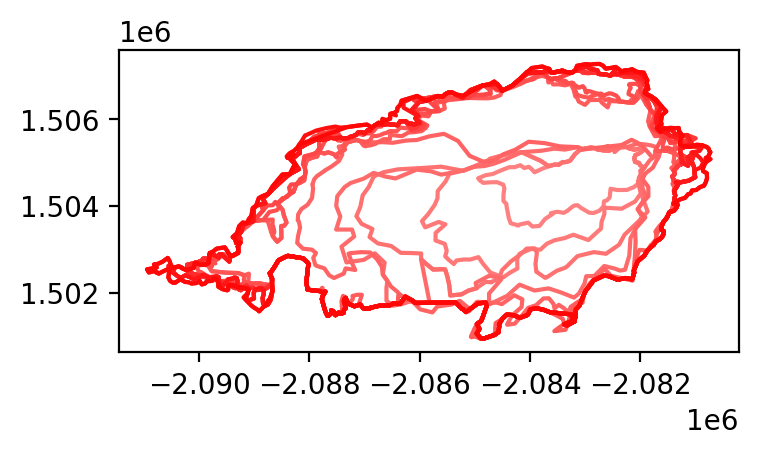

In [134]:
cm = LinearColormap(colors=[(255,128,128,255), (255,0,0,255)])
ix = 0

fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=200)
for i, vertices in enumerate(vertices_lst[:-2]):
    color = cm.rgba_hex_str(i/len(vertices_lst[:-2]))
    plot_perimeter(vertices, ax, color=color)
    # plot_perimeter(vertices[ix:ix+1], ax, marker='o')

In [137]:
xlim = (-2091454.505641569, -2080213.0233935725)
ylim = (1500625.682860173, 1507596.7094396015)

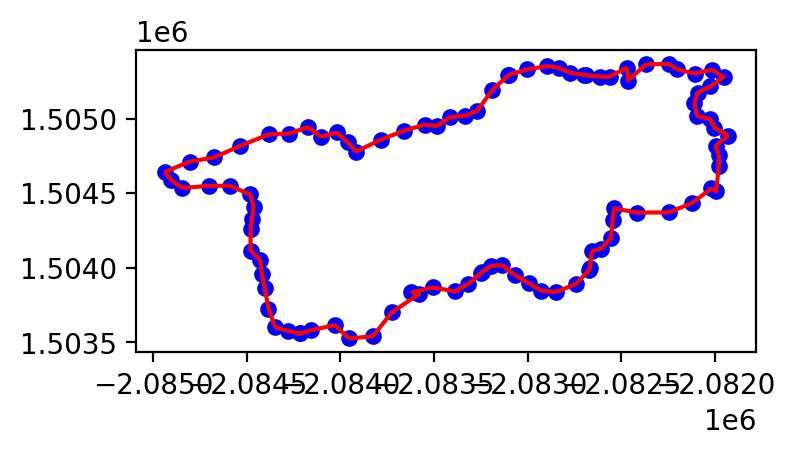

In [159]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
plot_perimeter(vertices_lst[0], ax, color='b',marker='o', markersize=5, linestyle='')
plot_perimeter(rotated_vertices_lst[0], ax, linestyle='-', linewidth=1.5, color='r')

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

(0.0, 550.0)

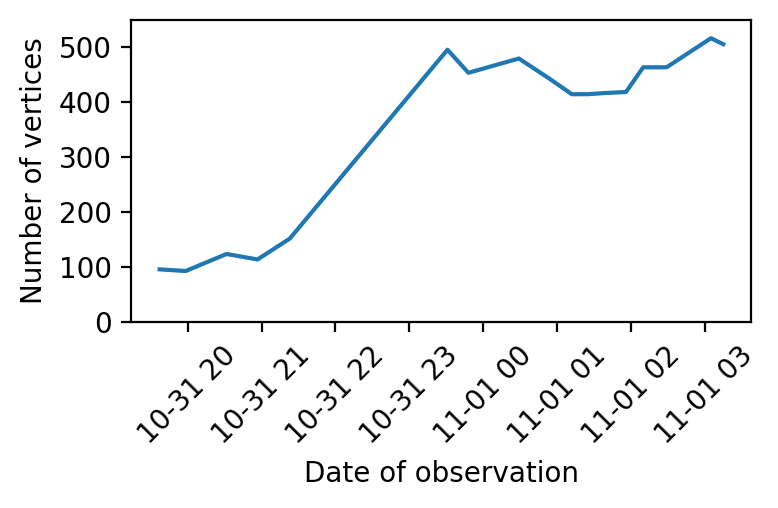

In [133]:
number_of_vertices = []
for vertices in vertices_lst:
    number_of_vertices.append(len(vertices))

fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax.plot(gdfMariaIgnition['datetime'].iloc[:-2], number_of_vertices[:-2])
ax.tick_params(axis='x', labelrotation=45)

ax.set_ylabel('Number of vertices')
ax.set_xlabel('Date of observation')

ax.set_yticks(np.arange(0,750,100))
ax.set_ylim(0,550)

f23196b034474744bdca7df94b13e0f7    2019-10-31 19:37:11
9f82e870591748a9a8a01346d174f2a1    2019-10-31 19:58:22
1a6eb30ee33742e18fa6bb26678b5077    2019-10-31 20:31:33
911f9b001c054b74a6ba70958f5f3c93    2019-10-31 20:56:44
7957c2e604554199ba60c5b13aff2f40    2019-10-31 21:22:55
714f0cf8d475462a97c651642a3d2525    2019-10-31 23:31:00
628d7730c0f149f898695d37a1350882    2019-10-31 23:48:00
746e4f286cba4af4a89362b548f2c255    2019-11-01 00:29:00
ec72de65d1934e0ab74ff46ffba1ae1b    2019-11-01 00:54:00
15dc4b77768f4921be77c65ae9a6b9d4    2019-11-01 01:12:00
db87bccf2de3464ea09ffbe2c1fe1611    2019-11-01 01:25:00
548466fe1b424e62bc8d766234763fa2    2019-11-01 01:38:00
116dd0ef296445f39a3343b0daa1a084    2019-11-01 01:56:00
9623320b87894822a5ec1429be08f9bd    2019-11-01 02:10:00
04983f027cb4496da5a4d1177d28a801    2019-11-01 02:24:00
57a3d3ce84b2401ea89da919252ede28    2019-11-01 02:29:00
c9c4975019b947eab1e825ea811e9156    2019-11-01 03:05:00
49716755b8444847b9e030fa52481e05    2019-11-01 0

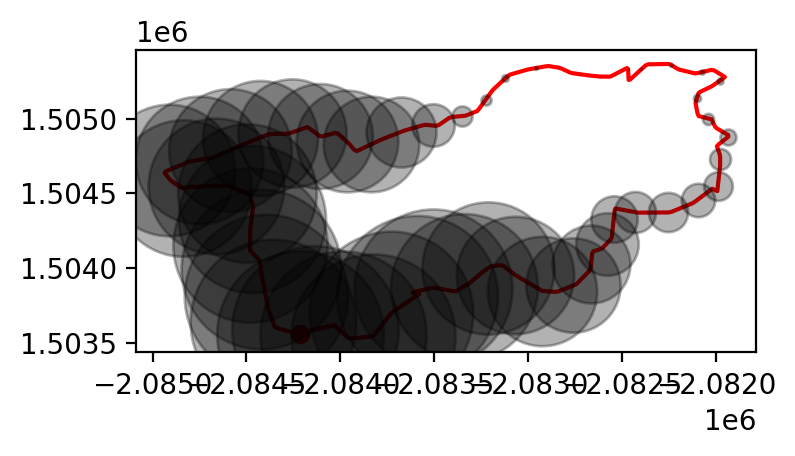

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
plot_perimeter(rotated_vertices_lst[0], ax)
for i in range(len(uncertainties_lst[0])):
    if i%10 == 0:
        ax.plot(rotated_vertices_lst[0][i][0] ,rotated_vertices_lst[0][i][1], 'o', 
                markersize=uncertainties_lst[0][i], color=(0,0,0,0.3))

In [29]:
gdfMariaKalman = pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')
gdfMariaKalman

,igniteidx,compareidx,description,datetime,filepath,windspeed,winddirection,configpath,geometry
a4fa385ce03d4464b464fdf1a69264f2,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00796/out_Peri...,3,79,/home/tcaglar/data/20220904/Run_00796/config,"POLYGON ((-2084966.000 1504639.000, -2084948.0..."
da394386715a4612a5e48c4edf7a20fe,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00788/out_Peri...,1,135,/home/tcaglar/data/20220904/Run_00788/config,"POLYGON ((-2084958.000 1504647.000, -2084930.0..."
6a39174fa122445589879970e8492f4c,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00794/out_Peri...,1,315,/home/tcaglar/data/20220904/Run_00794/config,"POLYGON ((-2084960.000 1504645.000, -2084931.0..."
506df62f19214c19b6b99d43ae456153,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00789/out_Peri...,1,270,/home/tcaglar/data/20220904/Run_00789/config,"POLYGON ((-2084959.000 1504647.000, -2084930.0..."
f63edd60af1c4a898a8083ae989e575d,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00795/out_Peri...,1,0,/home/tcaglar/data/20220904/Run_00795/config,"POLYGON ((-2084960.000 1504644.000, -2084931.0..."
ae80a96e55934f548129fad500e51ee1,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00800/out_Peri...,2,18,/home/tcaglar/data/20220904/Run_00800/config,"MULTIPOLYGON (((-2084964.000 1504640.000, -208..."
529dd7c9e5514d188060d62759e6482d,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00799/out_Peri...,3,63,/home/tcaglar/data/20220904/Run_00799/config,"POLYGON ((-2084967.000 1504636.000, -2084948.0..."
54170b1c9e0a4e32b24f900e468b0cce,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00793/out_Peri...,1,297,/home/tcaglar/data/20220904/Run_00793/config,"POLYGON ((-2084959.000 1504646.000, -2084930.0..."
2018d2d3abf34e3f90bdae0aa1796c62,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00801/out_Peri...,2,34,/home/tcaglar/data/20220904/Run_00801/config,"POLYGON ((-2084963.000 1504641.000, -2084937.0..."
3238f089e7da4a4e8ca2703b45fb5300,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00791/out_Peri...,0,0,/home/tcaglar/data/20220904/Run_00791/config,"POLYGON ((-2084959.000 1504646.000, -2084930.0..."


In [44]:
gdfMariaIgnition.loc['9f82e870591748a9a8a01346d174f2a1']

filetype                                                Ignition
objectid                                                   21232
filepath       /home/jovyan/farsite/inputs/maria_ignite/maria...
datetime                                     2019-10-31 19:58:22
description                                            Maria2019
geometry       POLYGON ((-2082034.4944368259 1504548.52022068...
Name: 9f82e870591748a9a8a01346d174f2a1, dtype: object

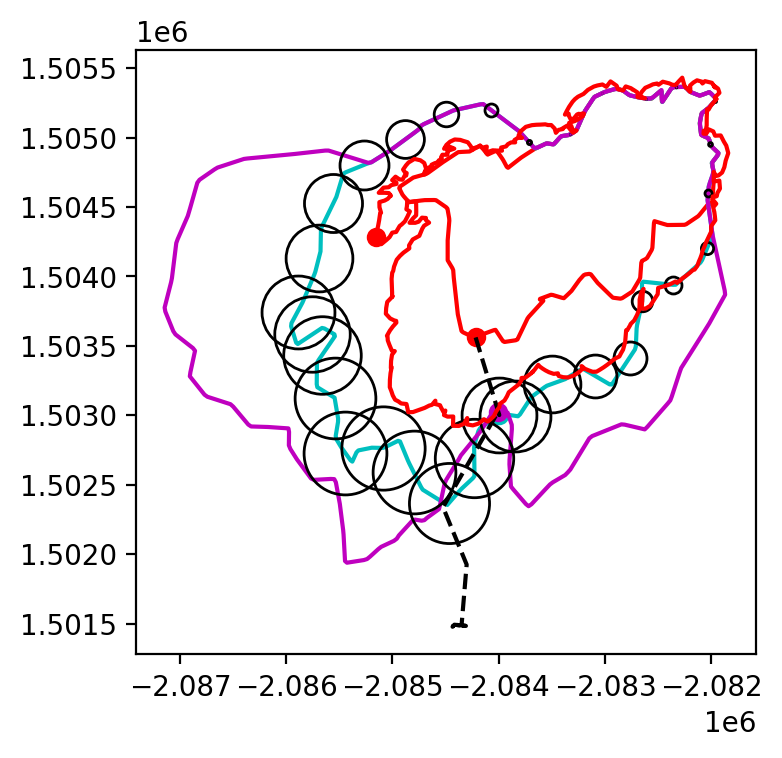

In [49]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ix = 0
uix = 1

dx = None

# test_vertices = list(gdfMariaIgnition.loc['9f82e870591748a9a8a01346d174f2a1', 'geometry'].exterior.coords)
plot_perimeter(rotated_vertices_lst[0], ax, 'r', ix, dx)
plot_perimeter(rotated_vertices_lst[1], ax, 'c', ix, dx)
# plot_perimeter(test_vertices, ax, 'k', 0, None)
plot_perimeter(rotated_vertices_lst[2], ax, 'm', ix, dx)
# plot_perimeter(rotated_vertices_lst[3], ax, 'y', ix, dx)
# plot_perimeter(rotated_vertices_lst[4], ax, 'b', ix, dx)
# plot_perimeter(rotated_vertices_lst[5], ax, 'r', ix, dx)
# plot_perimeter(rotated_vertices_lst[6], ax, 'c', ix, dx)
# plot_perimeter(rotated_vertices_lst[7], ax, 'm', ix, dx)
# plot_perimeter(rotated_vertices_lst[8], ax, 'y', ix, dx)

centroid = np.array(rotated_vertices_lst[uix]).mean(axis=0)
# ax.plot(centroid[0], centroid[1], 'ko')

trajectories_lst = calculate_trajectories(rotated_vertices_lst)
traj = np.array(trajectories_lst[ix])
ax.plot(traj[:,0], traj[:,1], 'k--')


for i in range(len(uncertainties_lst[uix])):
    if i%17 == 0:
        ax.plot(rotated_vertices_lst[uix][i][0] ,rotated_vertices_lst[uix][i][1], 'o', 
                markersize=uncertainties_lst[uix][i]/2, color=(0,0,0,1), fillstyle='none')
        
# gdf = gdfMariaKalman
gdf = gdfMariaSim[(gdfMariaSim['igniteidx'] == 'f23196b034474744bdca7df94b13e0f7') & 
                  (gdfMariaSim['winddirection'] == 50) &
                  (gdfMariaSim['windspeed'] == 15)]

# Plot the predictions
for gix, gdfrow in gdf.iterrows():
    geom = gdfrow['geometry']
    
    if isinstance(geom, MultiPolygon):
        geom = geom.geoms[0]
    
    vertices = list(geom.exterior.coords)
    plot_perimeter(vertices, ax, 'r', 0, None)
    

NameError: name 'pd' is not defined

In [3]:
gdfMariaIgnition

NameError: name 'gdfMariaIgnition' is not defined

In [116]:
%%time

compareidx = '9f82e870591748a9a8a01346d174f2a1'

vertices_observed = list(gdfMariaIgnition.loc[compareidx]['geometry'].exterior.coords)
centroid = gdfMariaIgnition.to_crs(epsg=4326).loc[compareidx, 'geometry'].centroid

fromdate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific') - datetime.timedelta(hours=6)
todate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific')
wxdata = collect_wx_data(centroid, fromdate, todate)

https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.31448975046044&lon=-119.04499757335803&radius=8.0467&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-31T13:48:22-07:00&to=2019-10-31T20:08:22-07:00
CPU times: user 27.4 ms, sys: 3.91 ms, total: 31.3 ms
Wall time: 1.14 s


In [119]:
station_data = []
for feature in wxdata['features']:
    name = feature['properties']['description']['name']
    wifireuid = feature['properties']['description']['wifire_uid']
    
    
    distance = feature['properties']['distanceFromLocation']
    coordinates = feature['geometry']['coordinates']
    
    times = pd.to_datetime(feature['properties']['timestamp'])
    
    units = feature['properties']['units']
    temperatures = feature['properties']['temperature']
    windspeeds = feature['properties']['wind_speed']
    winddirections = feature['properties']['wind_direction']
    
    print(f'name: {name}\ndist: {distance}')
    
    station_data.append({'name': name,
                         'time': times,
                         'windspeed': windspeeds,
                         'winddirection': winddirections,
                         'temperature': temperatures,
                         'units': units,
                         'coordinates': coordinates,
                         'distance': distance,
                         'wifireuid': wifireuid})
    

name: Santa Paula
dist: {'value': 5.43892704486433, 'units': 'km'}
name: CW7664 Santa Paula
dist: {'value': 5.2342451317562215, 'units': 'km'}
name: South Mountain West
dist: {'value': 5.538991102515389, 'units': 'km'}
name: SOMIS (P729) CA
dist: {'value': 7.700694487962863, 'units': 'km'}
name: SCE Bradley Rd
dist: {'value': 4.7565280156685255, 'units': 'km'}
name: SCE South Mountain
dist: {'value': 3.8302247459284064, 'units': 'km'}
name: SCE Balcom Canyon
dist: {'value': 6.5931862596116035, 'units': 'km'}
name: SCE Bixby Rd
dist: {'value': 7.63675324926908, 'units': 'km'}
name: SCE Camarillo Hills
dist: {'value': 7.0560935663803175, 'units': 'km'}
name: SCE Santa Paula
dist: {'value': 4.950434175208628, 'units': 'km'}
name: SCE Hondo Barranca Rd
dist: {'value': 1.627621373202783, 'units': 'km'}
name: SCE North Peck Rd
dist: {'value': 5.560184983310616, 'units': 'km'}


In [8]:
df = pd.DataFrame(index=times, data={'temperature': temperatures, 'windspeed': windspeeds, 'winddirection': winddirections})
df['U'] = df['windspeed']*np.cos(df['winddirection']/180*np.pi)
df['V'] = df['windspeed']*np.sin(df['winddirection']/180*np.pi)
df['hour'] = df.index.hour
df = df.sort_index()

In [9]:
x = df.dropna()['U'].values
y = df.dropna()['V'].values
t = df.dropna().index

alpha_range = np.arange(1, len(x)+1)/len(x)
colors = []
for alpha in alpha_range:
    colors.append((0,0,1,alpha))
cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])
    
tdiff_seconds = (t - t[0]).total_seconds()
weights = tdiff_seconds/tdiff_seconds.max()
    
# plot_binned_winds(x, y, weights, 15, 51, df.iloc[-1].index.name)
edge_value = 15
bin_counts = 51
XY = calculate_binned_winds(x, y, weights, edge_value, bin_counts)
ixmax, jxmax = np.unravel_index(XY.argmax(), XY.shape)

delta = 2*edge_value/bin_counts
xmaxbin = (-edge_value + ixmax*delta, -edge_value + (ixmax+1)*delta)
ymaxbin = (-edge_value + jxmax*delta, -edge_value + (jxmax+1)*delta)


In [10]:
xix, yix = np.where(XY>0)
xmeans = -edge_value + (xix+0.5)*delta
ymeans = -edge_value + (yix+0.5)*delta

weights = XY[xix, yix]/XY.sum()

windspeed = np.round(np.sqrt(xmeans**2 + ymeans**2)).astype(int)
winddirection = np.round(np.arctan2(ymeans, xmeans)*180/np.pi).astype(int)
winddirection[np.where(winddirection<0)[0]] += 360

In [11]:
pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')

,igniteidx,compareidx,description,datetime,filepath,windspeed,winddirection,configpath,geometry
a4fa385ce03d4464b464fdf1a69264f2,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00796/out_Peri...,3,79,/home/tcaglar/data/20220904/Run_00796/config,"POLYGON ((-2084966.000 1504639.000, -2084948.0..."
da394386715a4612a5e48c4edf7a20fe,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00788/out_Peri...,1,135,/home/tcaglar/data/20220904/Run_00788/config,"POLYGON ((-2084958.000 1504647.000, -2084930.0..."
6a39174fa122445589879970e8492f4c,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00794/out_Peri...,1,315,/home/tcaglar/data/20220904/Run_00794/config,"POLYGON ((-2084960.000 1504645.000, -2084931.0..."
506df62f19214c19b6b99d43ae456153,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00789/out_Peri...,1,270,/home/tcaglar/data/20220904/Run_00789/config,"POLYGON ((-2084959.000 1504647.000, -2084930.0..."
f63edd60af1c4a898a8083ae989e575d,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00795/out_Peri...,1,0,/home/tcaglar/data/20220904/Run_00795/config,"POLYGON ((-2084960.000 1504644.000, -2084931.0..."
ae80a96e55934f548129fad500e51ee1,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00800/out_Peri...,2,18,/home/tcaglar/data/20220904/Run_00800/config,"MULTIPOLYGON (((-2084964.000 1504640.000, -208..."
529dd7c9e5514d188060d62759e6482d,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00799/out_Peri...,3,63,/home/tcaglar/data/20220904/Run_00799/config,"POLYGON ((-2084967.000 1504636.000, -2084948.0..."
54170b1c9e0a4e32b24f900e468b0cce,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00793/out_Peri...,1,297,/home/tcaglar/data/20220904/Run_00793/config,"POLYGON ((-2084959.000 1504646.000, -2084930.0..."
2018d2d3abf34e3f90bdae0aa1796c62,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00801/out_Peri...,2,34,/home/tcaglar/data/20220904/Run_00801/config,"POLYGON ((-2084963.000 1504641.000, -2084937.0..."
3238f089e7da4a4e8ca2703b45fb5300,f23196b034474744bdca7df94b13e0f7,9f82e870591748a9a8a01346d174f2a1,Maria2019,2019-10-31 19:58:11,/home/tcaglar/data/20220904/Run_00791/out_Peri...,0,0,/home/tcaglar/data/20220904/Run_00791/config,"POLYGON ((-2084959.000 1504646.000, -2084930.0..."


array([-2083346.93015784,  1504527.41737275])

Calculating for ws=[1 1 1 0 1 1 1 1 3 1 2 3 2 2 2 3 2 3 3 3 4 4 5 6], wd=[135 270 270   0  90 297 315   0  79  27  56  63  18  34  45  53  14  27
  37  22  27  34  36  37]


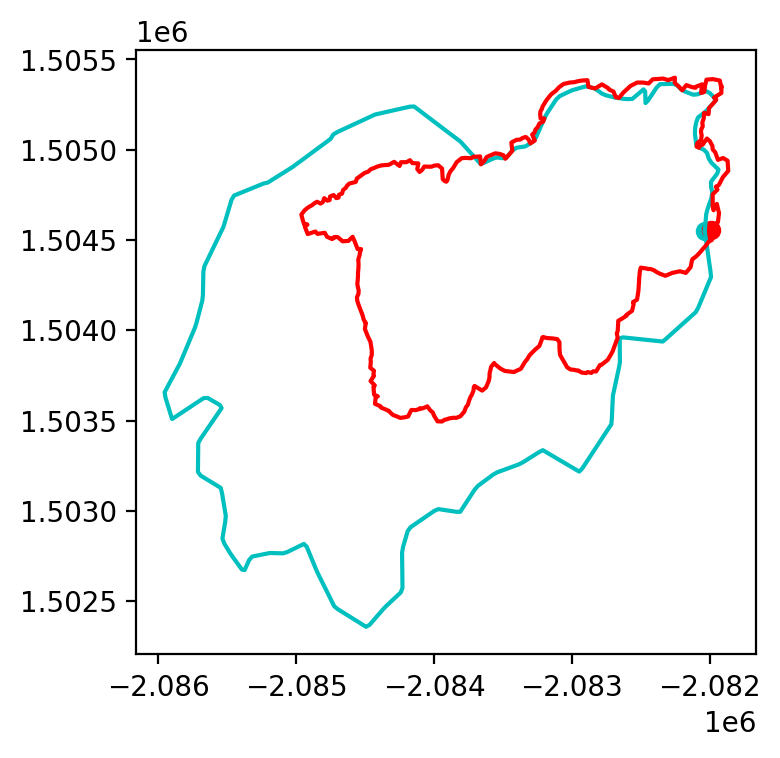

In [14]:
# windspeeds = gdfMariaSim['windspeed'].unique()
# winddirections = gdfMariaSim['winddirection'].unique()

# wsidx = 10
# wdidx = 15

gdfMariaSim = pd.read_pickle('./Maria2019_simulation_Kalman_1.pkl')
idx = 10

ws = windspeed[idx]
wd = winddirection[idx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == ws) &
                                      (gdfMariaSim['winddirection'] == wd)].iloc[0]['geometry'].exterior.coords)
vertices_observed = gdfMariaIgnition.iloc[1]['geometry'].exterior.coords

vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')

In [18]:
len(vertices_B)

410

In [21]:
def plot_wind_values(x, y, alpha_range, colors, title):
    # Returns fig, ax

    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.set_aspect('equal')
    plt.subplots_adjust(left=0.2)
    ax.scatter(x, y, color=colors, edgecolors='none')

    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax

## Creating animations

In [31]:
number_of_steps = 500
first_ix = 3000
final_ix = len(df)
startix = first_ix
endix = startix + number_of_steps

number_of_frames = final_ix - first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().iloc[startix:endix].index.values.astype(np.int64)/1e9
    
    alpha_range = np.arange(1, len(x)+1)/len(x)
    colors = []
    for alpha in alpha_range:
        colors.append((0,0,1,alpha))
    
    fig, ax = plot_wind_values(x, y, alpha_range, colors,
                             title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1
    
    fig.savefig(f'scatter_movie/scatter_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [15]:
! ffmpeg -f image2 -r 20 -i scatter_movie/scatter_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p scatter_500.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [ ]:
! scp scatter_500.mp4 hotshot:/home/tcaglar/

In [27]:

def plot_binned_winds(x, y, weights, edge_value, bin_counts, title):
    XY = calculate_binned_winds(x, y, weights, edge_value, bin_counts)

    cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])
    
    
    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.imshow(XY.T, extent=[-edge_value,edge_value,-edge_value,edge_value],
               origin='lower', cmap = cmap, aspect='equal')
        
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax


In [10]:
number_of_steps = 500
first_ix = len(df)-1000
final_ix = len(df)
startix = first_ix
edge_value = 15
bin_counts = 51

endix = startix + number_of_steps

alpha_range = np.arange(1, number_of_steps+1)/number_of_steps

cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])

number_of_frames = final_ix-first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().index[startix:endix]

    tdiff_seconds = (t - t[0]).total_seconds()
    weights = tdiff_seconds/tdiff_seconds.max()
    
    fig, ax = plot_binned_winds(x, y, weights, edge_value, bin_counts,
                                title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1

    fig.savefig(f'binned_movie/binned_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [11]:
! ffmpeg -f image2 -r 20 -i binned_movie/binned_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p binned_500.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [ ]:
! scp binned_500.mp4 hotshot:/home/tcaglar/

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [195]:
# ! scp out.mp4 hotshot:/home/tcaglar/

tcaglar@hotshot.sdsc.edu's password: 


### Test for KMeans clustering

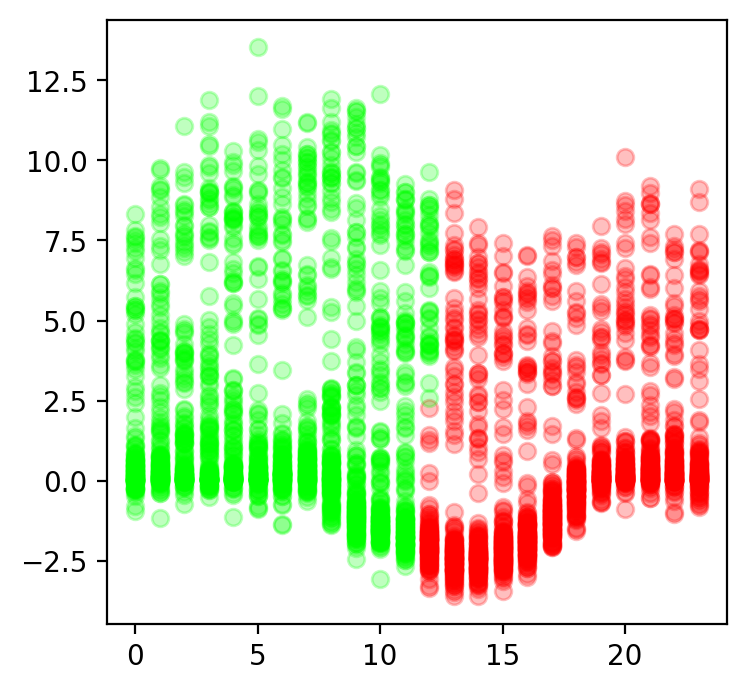

In [209]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=3000, tol=1e-04, random_state=120)

X = df[['hour', 'U', 'V']].dropna().to_numpy()
# X = X[3000:]
y_km = km.fit_predict(X)

fig, ax = plt.subplots(1,1 , figsize=(4,4), dpi=200)

for i in np.unique(y_km):
    mask = np.where(y_km == i)[0]
    ax.plot(X[mask,0], X[mask,1], 'o', color=colors[i])

# ax.set_xlim(-5,15)
# ax.set_ylim(-5,15)

In [133]:
hours_diff = 6
bins = np.arange(0,24.1, hours_diff, dtype=int)

for i, (left, right) in enumerate(zip(bins[:-1], bins[1:])):
    df.loc[((df.index.hour >= left) & (df.index.hour < right)),'type'] = i
    
df['type'] = df['type'].astype(int)

df['type'].nunique()

4

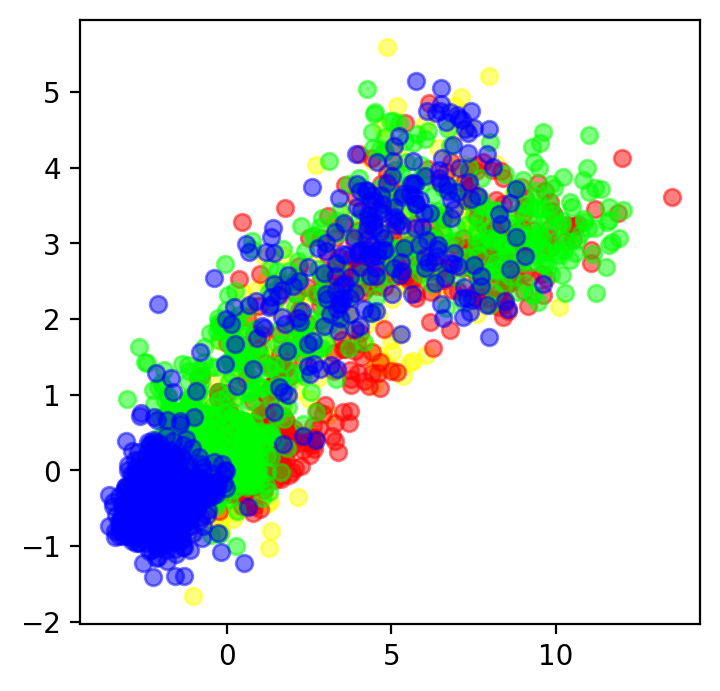

In [134]:
idx0 = np.where(y_km==0)[0]
idx1 = np.where(y_km==1)[0]



fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in df['type'].unique():
    mask = (df['type']==i)
    
    ax.plot(df[mask]['U'], df[mask]['V'], 'o', color=colors[i])




### Test for time-series convolution

In [9]:
t, v, clip_idx = convolve_timeseries(times, windspeeds, hours=3)
plt.plot(t, windspeeds[clip_idx:-clip_idx], t, v, 'o')

# This will be the std.dev to select wind speeds
sigma_wx = np.sqrt(sum((v - windspeeds[clip_idx:-clip_idx])**2))

NameError: name 'convolve_timeseries' is not defined

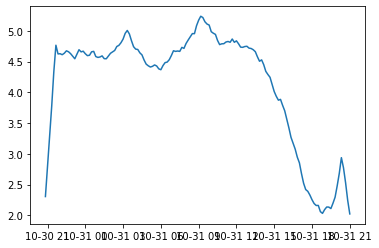

In [141]:
plt.plot(times, np.convolve(windspeeds, np.ones(10), mode='same')/sum(np.ones(10)))

## Compare perimeters

In [10]:
windspeeds = gdfMariaSim['windspeed'].unique()
winddirections = gdfMariaSim['winddirection'].unique()

wsidx = 10
wdidx = 15

windspeed = windspeeds[wsidx]
winddirection = winddirections[wdidx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &
                                      (gdfMariaSim['winddirection'] == winddirection) &
                                      (gdfMariaSim['compareidx'] == compareidx)].iloc[0]['geometry'][0].exterior.coords)
vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')

Calculating for ws=10.0, wd=90.0


/tmp/ipykernel_49/3259605093.py:12: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &


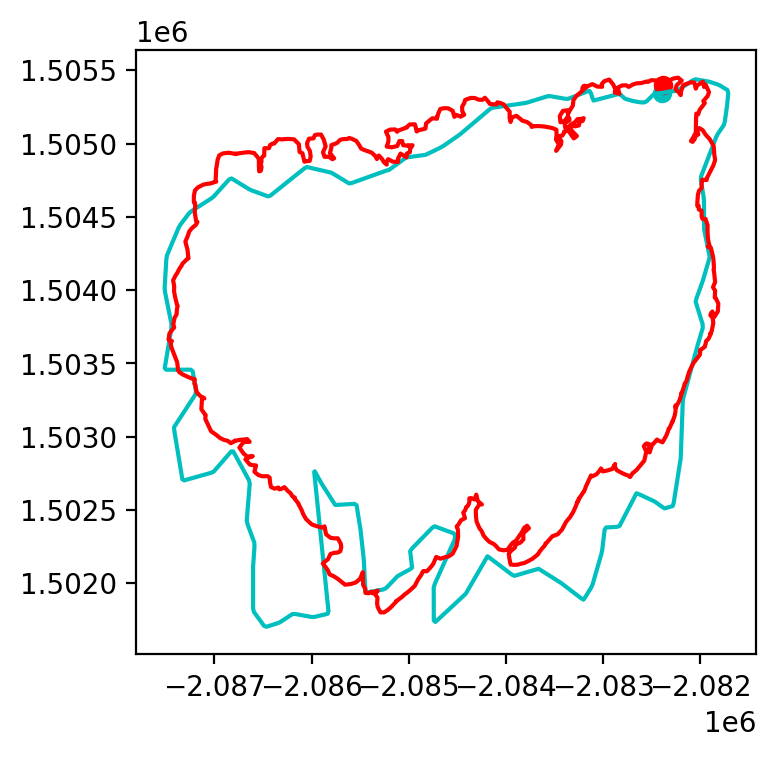